<div class="alert alert-block alert-info">

<b>Note:</b> this template was adpated from TeachOpenCADD's [GitHub repository](https://github.com/volkamerlab/teachopencadd).

</div>

# {{Hierarchical Graph Neural Networks}}

**Note:** This talktorial was created as a part of the 2024 [Hands-on Graph Neural Networks seminar](https://cms.sic.saarland/hognn2024/) at Saarland University.

Author:
- Mohammad Shaique Solanki, MSc Bioinformatics, [CruelMarco/Github](https://github.com/CruelMarco)

## Aim of this talktorial

The aim of this talk-torial is to give a breif introduction about Hierarchical Graph Neural Networks (HGNNs). The notebook will dive a little deeper into why HGNNs came into existence in the first place. Theory of how it works along with a pratical implementation using Differential Pooling Mechanism is also shown in this talk-torial. Its aim is to provide a basic understanding of the underlying concepts and to demonstrate how to apply graph neural networks to a graph-level task using a hands-on example

**Table of Contents (TOC)**

- [**1. What are GNNs?**](#what_are_gnns)
- [**2. Loading and visualing proteins dataset from TUDataset**](#visualising_the_heirarchies)
- [**3. Flat GNN Architecture - GCN, GraphSage**](#flat_gnn_architecture)
    - [3.1 Graph Convolution Networks (GCN)](#gcn)
    - [3.2 GraphSage](#graphsage)
    - [3.3 Training a GCN based binary classification GNN](#trainingflat)
- [**4. Challenges with flat GNNs**](#challenges)
- [**5. Introduction to Hierarchical Graph Neural Networks**](#hgnn)
    - [5.1 Efficient Computation through Coarsening](#coarsening)
    - [5.2 Capturing the Hierarchical Structure](#h_structure)
- [**6. Diffpool Mechanism**](#diffpool)
- [**7. Training a GNN using Diffpool Mechanism**](#training_dp)
- [**8. Discussions**](#discussion)
- [**9. Quiz**](#quiz)


## References

<div class="alert alert-block alert-info">

If you refer to publications in your talktorial, please gather them here.
If there are any other important reference you used, e.g. further reading material, external code repositories, ..., please also list them here.

</div>


- Hierarchical graph representation learning with differentiable pooling." (2019): [Ying, Zhitao, et al., Neurips(2019)]
- [PyTorch Geometric package](https://pytorch-geometric.readthedocs.io/en/latest/)
- [Hierarchical Graph Representation Learning with Differentiable Pooling](https://github.com/d-stoll/diffpool/blob/main/README.md)
- [Protein Diffpool](https://github.com/pyg-team/pytorch_geometric/blob/master/examples/proteins_diff_pool.py)
- [Classifying the Proteins Benchmark Dataset](https://towardsdatascience.com/classifying-the-proteins-benchmark-dataset-ec18e728a17a)



## Python Dependencies

*If setting up a Python environment that runs your code requires some nasty extra steps, **HERE** is the place to mention them.*

In [1]:
requirements = """
aiohappyeyeballs==2.4.4
aiohttp==3.11.11
aiosignal==1.3.2
appnope==0.1.4
asttokens==3.0.0
async-timeout==5.0.1
attrs==25.1.0
certifi==2024.12.14
charset-normalizer==3.4.1
comm==0.2.2
contourpy==1.3.0
cycler==0.12.1
debugpy==1.8.12
decorator==5.1.1
exceptiongroup==1.2.2
executing==2.2.0
filelock==3.17.0
fonttools==4.55.6
frozenlist==1.5.0
fsspec==2024.12.0
idna==3.10
importlib_metadata==8.6.1
importlib_resources==6.5.2
ipykernel==6.29.5
ipython==8.18.1
jedi==0.19.2
Jinja2==3.1.5
jupyter_client==8.6.3
jupyter_core==5.7.2
kiwisolver==1.4.7
MarkupSafe==3.0.2
matplotlib==3.9.4
matplotlib-inline==0.1.7
mpmath==1.3.0
multidict==6.1.0
nest-asyncio==1.6.0
networkx==3.2.1
numpy==2.0.2
packaging==24.2
parso==0.8.4
pexpect==4.9.0
pillow==11.1.0
platformdirs==4.3.6
prompt_toolkit==3.0.50
propcache==0.2.1
psutil==6.1.1
ptyprocess==0.7.0
pure_eval==0.2.3
Pygments==2.19.1
pyparsing==3.2.1
python-dateutil==2.9.0.post0
pyzmq==26.2.0
requests==2.32.3
six==1.17.0
stack-data==0.6.3
sympy==1.13.1
torch==2.5.1
torch-geometric==2.6.1
torchaudio==2.5.1
torchvision==0.20.1
tornado==6.4.2
tqdm==4.67.1
traitlets==5.14.3
typing_extensions==4.12.2
urllib3==2.3.0
wcwidth==0.2.13
yarl==1.18.3
zipp==3.21.0
"""

In [2]:
import os.path as osp
import time
from math import ceil
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DenseDataLoader
from torch_geometric.nn import DenseSAGEConv, dense_diff_pool, GCNConv , global_mean_pool
import networkx as nx
from torch_geometric.utils import to_networkx
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
import torch
from torch_geometric.datasets import TUDataset
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.data import DataLoader
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from torch.optim.lr_scheduler import StepLR


In [3]:
torch.manual_seed(12345)

## Contents


## 1. What are GNNs <a id="what_are_gnns"></a>

Graph Neural Networks (GNNs) are designed to process data that is represented in graph forms, such as social networks, molecular structures, or communication networks. Unlike traditional neural networks, GNNs retain a state that can represent information from its neighborhood with arbitrary depth.

A typical GNN model updates the node states iteratively using information aggregated from the neighbors, based on the formula:

The general update formula in a GNN is:
$$
h^{(l+1)}_i = \sigma \left( W^{(l)} \sum_{j \in \mathcal{N}(i)} \frac{h^{(l)}_j}{|\mathcal{N}(i)|} + B^{(l)} h^{(l)}_i \right)
$$
where $h^{(l)}_i$ is the feature vector of node $i$ at layer $l$, $\mathcal{N}(i)$ includes the neighbors of $i$, $W^{(l)}$ and $B^{(l)}$ are learnable parameters, and $\sigma$ is a nonlinear activation function.


## 2. Loading and visualing proteins dataset from TUDataset <a id="visualising_the_heirarchies"></a>

### Visualizing Graphs from the Dataset
This section visualizes 10 graphs from the dataset to provide a visual understanding of the graph structures involved. We also perform a basic Agglomerative Clustering with 4 clusters. Then we proceed to draw a dendogram to show the heirarchy structure in the proteins molecule. We use `networkx` to convert the graph data from PyTorch Geometric to NetworkX format, then plot these using `matplotlib`.


In [4]:
max_nodes = 620

path = "./data_sets"


dataset = TUDataset(
    path,
    name='PROTEINS',
    transform=T.ToDense(max_nodes),
    pre_filter=lambda data: data.num_nodes <= max_nodes,
)
dataset = dataset.shuffle()
n = (len(dataset) + 9) // 10
test_dataset = dataset[:n]
val_dataset = dataset[n:2 * n]
train_dataset = dataset[2 * n:]
test_loader = DenseDataLoader(test_dataset, batch_size=20)
val_loader = DenseDataLoader(val_dataset, batch_size=20)
train_loader = DenseDataLoader(train_dataset, batch_size=20)


/Users/shaique/Desktop/BioInf_IMP/Bioinf_WS_2024/HO_GNN/HGNN/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:796: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/var/folders/7z/v5vlp84n7pl7lqlv_7xw5_z40000gn/T/ipykernel_9676/2177120215.py:38: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(adjacency_matrix, method='ward')
/Users/shaique/Desktop/BioInf_IMP/Bioinf_WS_2024/HO_GNN/HGNN/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:796: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/var/folders/7z/v5vlp84n7pl7lqlv_7xw5_z40000gn/T/ipykernel_9676/2177120215.py:38: ClusterWarning: The symmetric non-negative hollow ob

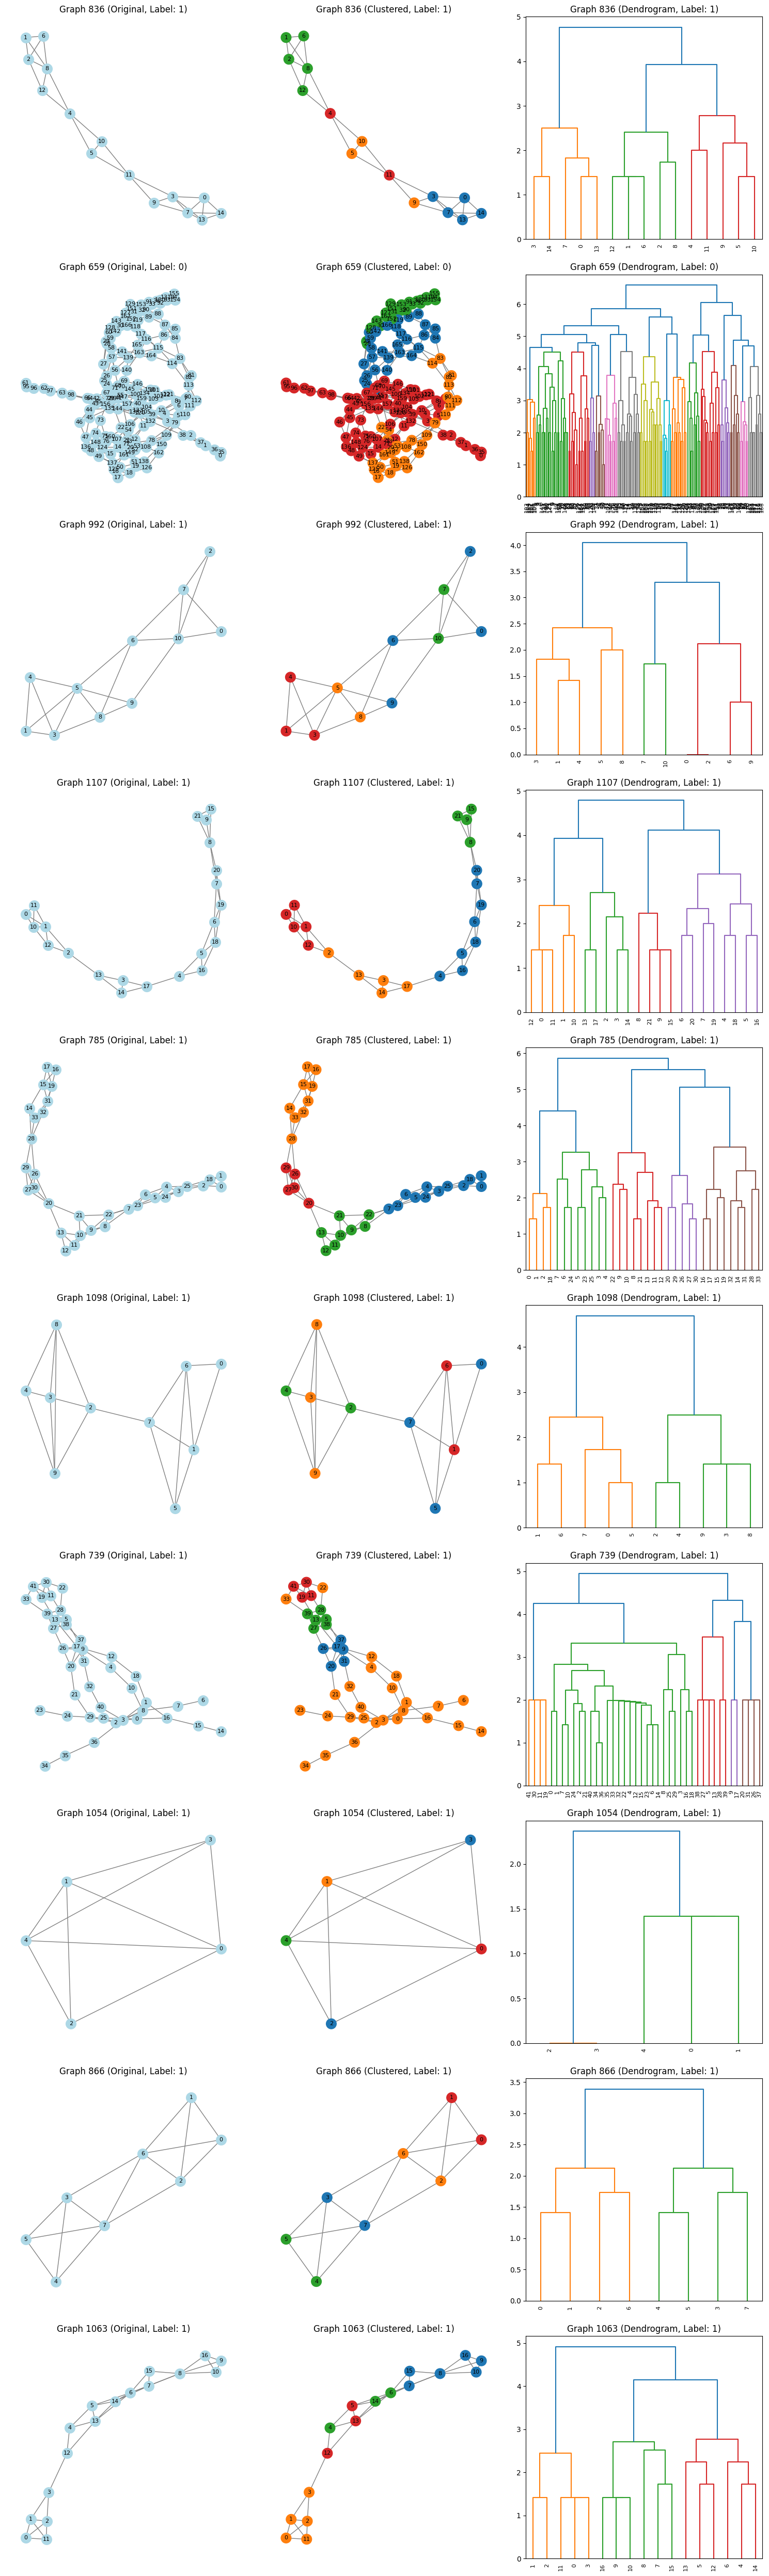

In [9]:
dataset_plot = TUDataset(root='./data/TUDataset', name='PROTEINS')

def hierarchical_clustering(G, n_clusters=4):
    adjacency_matrix = nx.adjacency_matrix(G).todense()
    #clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
    clustering = AgglomerativeClustering(n_clusters=n_clusters)

    clustering.fit(adjacency_matrix)
    clusters = clustering.labels_
    for i, node in enumerate(G.nodes):
        G.nodes[node]['cluster'] = clusters[i]
    return clusters

num_graphs = min(10, len(dataset_plot)) # Make sure we don't try to access more graphs than available
indices = torch.randint(0, len(dataset_plot), (num_graphs,))
graphs = [dataset_plot[i] for i in indices]

fig, axes = plt.subplots(num_graphs, 3, figsize=(15, 5 * num_graphs)) # Adjust figure height dynamically

for i, graph_data in enumerate(graphs):
    G = to_networkx(graph_data, to_undirected=True)
    graph_label = graph_data.y.item()  # Get the binary classification label

    ax = axes[i, 0] if num_graphs > 1 else axes[0]
    ax.set_title(f"Graph {indices[i].item()} (Original, Label: {graph_label})")
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=200, font_size=8, ax=ax)

    clusters = hierarchical_clustering(G)
    ax = axes[i, 1] if num_graphs > 1 else axes[1]
    ax.set_title(f"Graph {indices[i].item()} (Clustered, Label: {graph_label})")
    cluster_colors = [f'C{cluster}' for cluster in clusters]
    nx.draw(G, pos, with_labels=True, node_color=cluster_colors, edge_color='gray', node_size=200, font_size=8, ax=ax)

    ax = axes[i, 2] if num_graphs > 1 else axes[2]
    ax.set_title(f"Graph {indices[i].item()} (Dendrogram, Label: {graph_label})")
    adjacency_matrix = nx.adjacency_matrix(G).todense()
    linkage_matrix = linkage(adjacency_matrix, method='ward')
    dendrogram(linkage_matrix, labels=list(G.nodes), leaf_rotation=90, ax=ax, leaf_font_size=8)

plt.tight_layout()
plt.show()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/cluster/hierarchy.py:796: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/var/folders/7z/v5vlp84n7pl7lqlv_7xw5_z40000gn/T/ipykernel_26428/1182533279.py:38: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(adjacency_matrix, method='ward')
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/cluster/hierarchy.py:796: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/var/folders/7z/v5vlp84n7pl7lqlv_7xw5_z40000gn/T/ipykernel_26428/1182533279.py:38: ClusterWarning: The symmetric non-negative hollow observation matrix

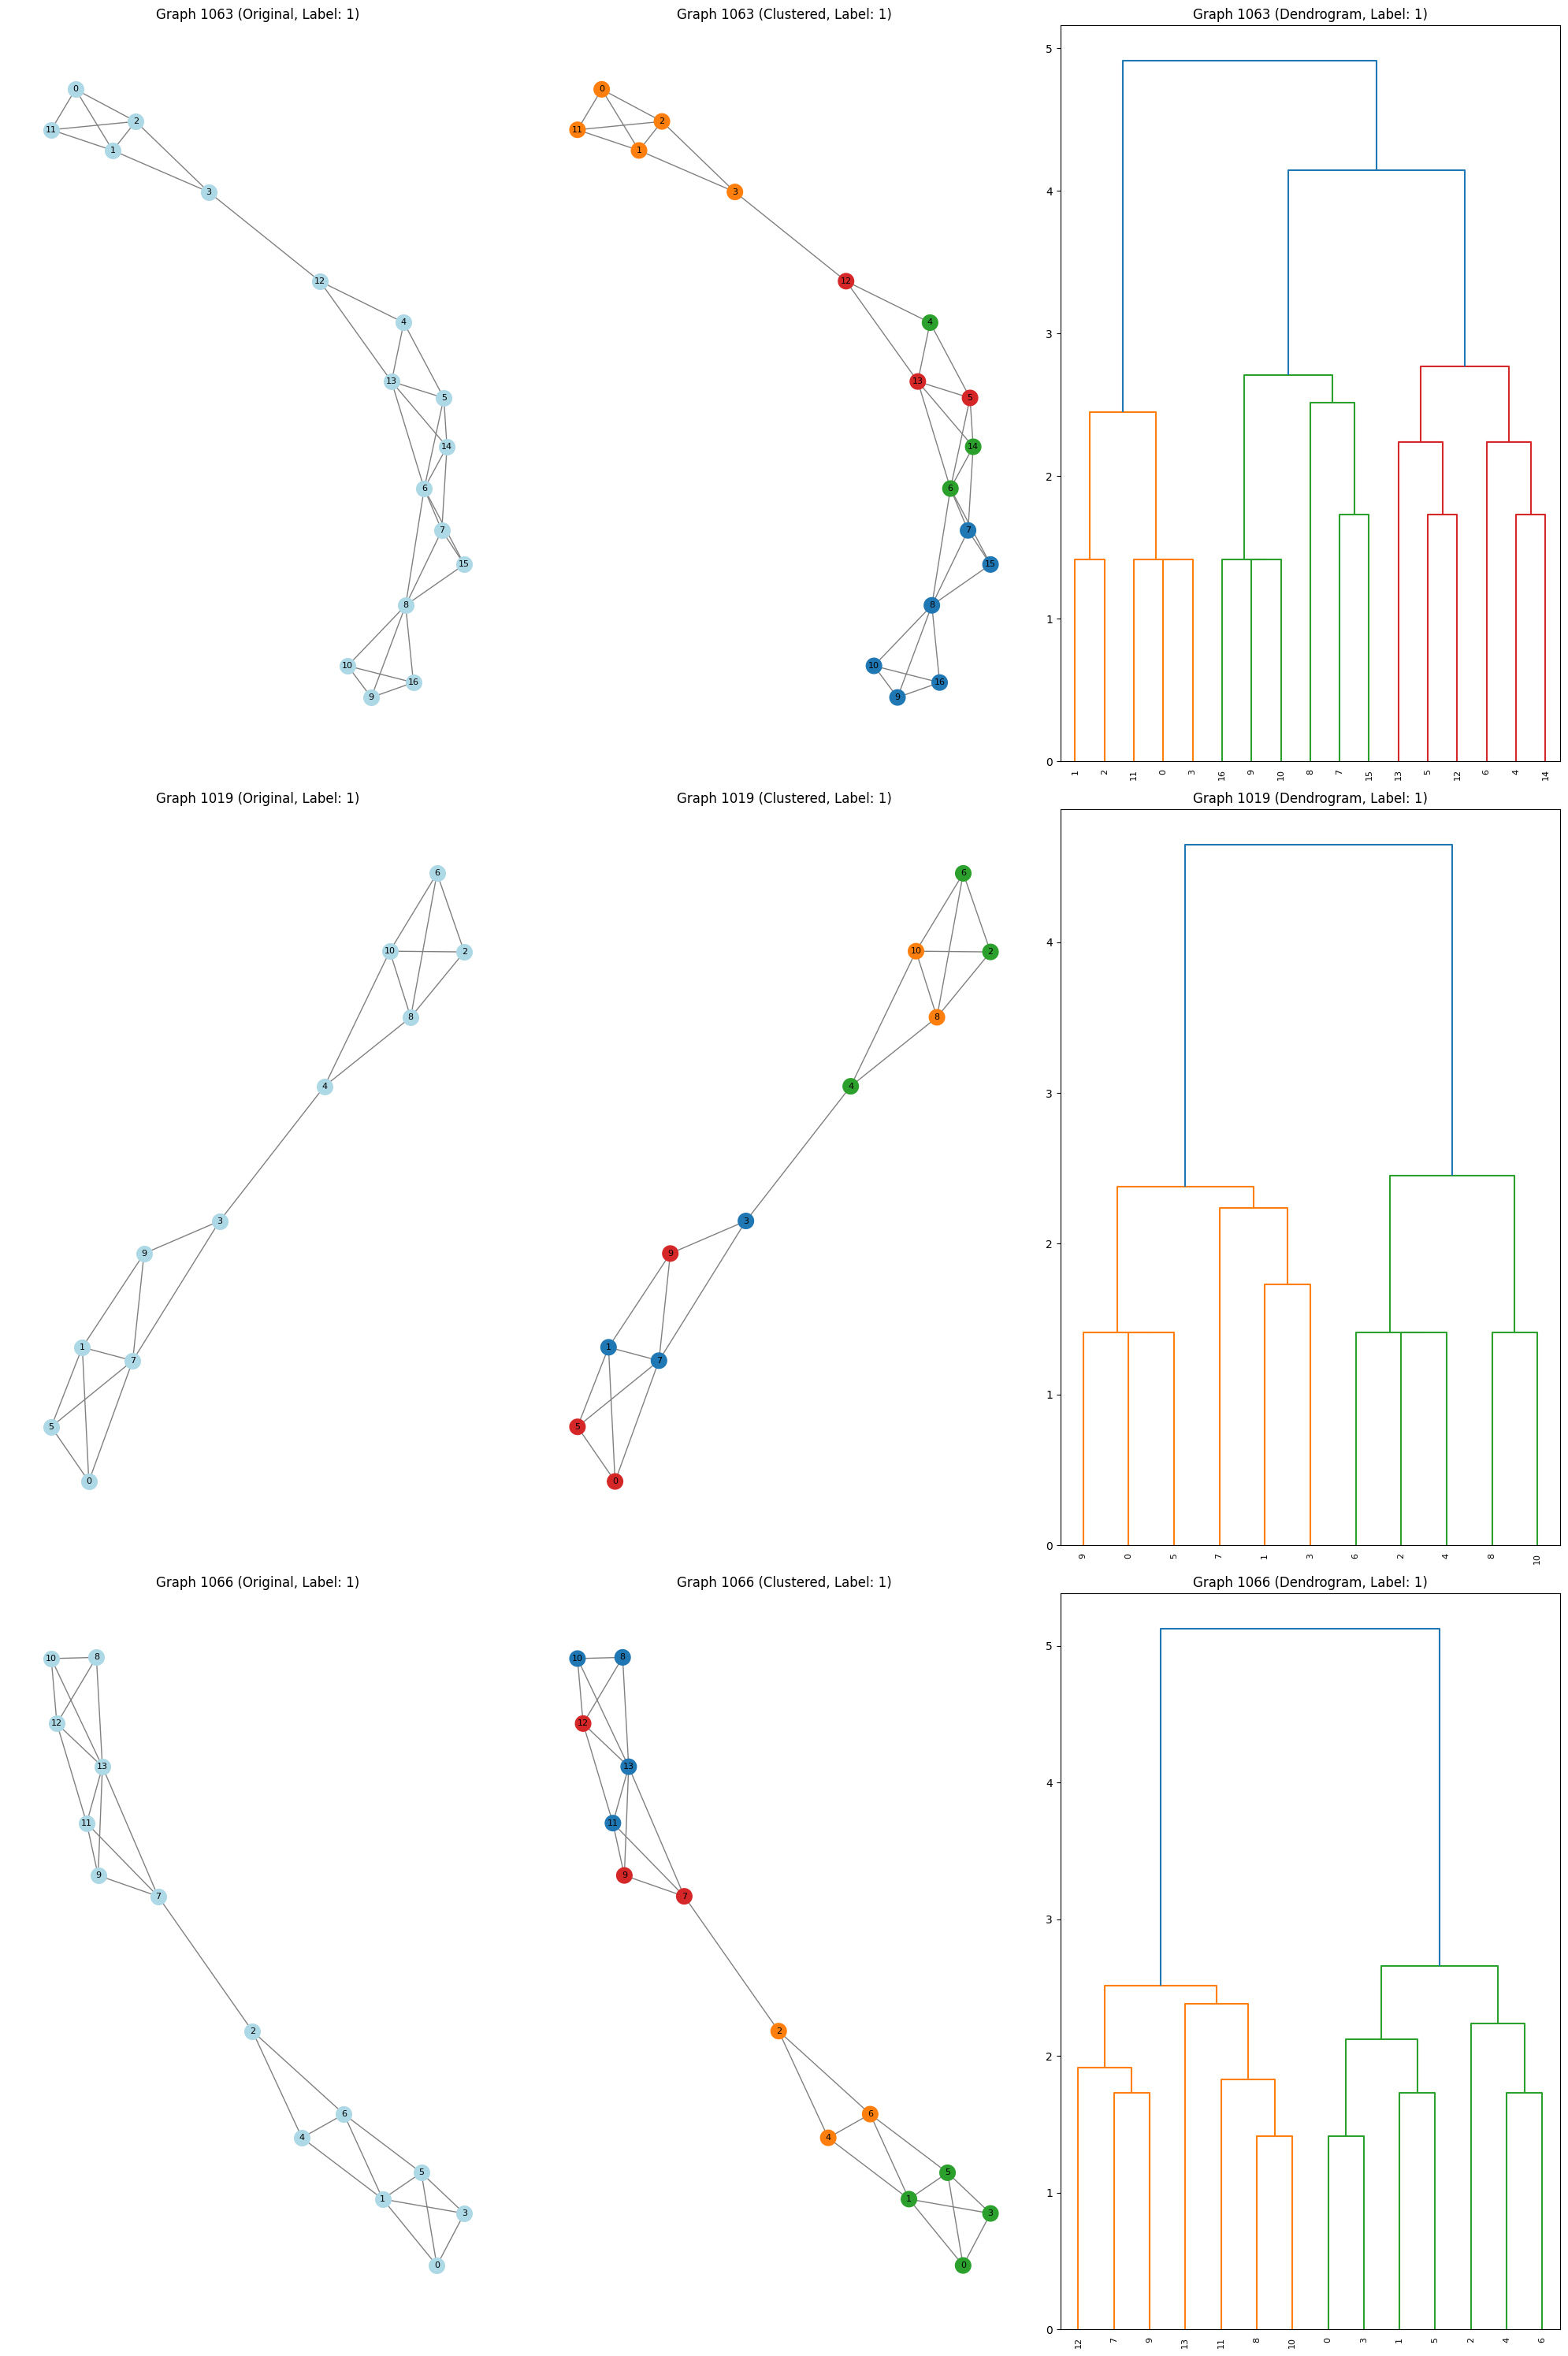

In [8]:
dataset_plot = TUDataset(root='./data/TUDataset', name='PROTEINS')

def hierarchical_clustering(G, n_clusters=4):
    adjacency_matrix = nx.adjacency_matrix(G).todense()
    #clustering = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
    clustering = AgglomerativeClustering(n_clusters=n_clusters)

    clustering.fit(adjacency_matrix)
    clusters = clustering.labels_
    for i, node in enumerate(G.nodes):
        G.nodes[node]['cluster'] = clusters[i]
    return clusters

num_graphs = min(3, len(dataset_plot)) # Make sure we don't try to access more graphs than available
indices = torch.randint(0, len(dataset_plot), (num_graphs,))
graphs = [dataset_plot[i] for i in indices]

fig, axes = plt.subplots(num_graphs, 3, figsize=(20, 10 * num_graphs)) # Adjust figure height dynamically

for i, graph_data in enumerate(graphs):
    G = to_networkx(graph_data, to_undirected=True)
    graph_label = graph_data.y.item()  # Get the binary classification label

    ax = axes[i, 0] if num_graphs > 1 else axes[0]
    ax.set_title(f"Graph {indices[i].item()} (Original, Label: {graph_label})")
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=200, font_size=8, ax=ax)

    clusters = hierarchical_clustering(G)
    ax = axes[i, 1] if num_graphs > 1 else axes[1]
    ax.set_title(f"Graph {indices[i].item()} (Clustered, Label: {graph_label})")
    cluster_colors = [f'C{cluster}' for cluster in clusters]
    nx.draw(G, pos, with_labels=True, node_color=cluster_colors, edge_color='gray', node_size=200, font_size=8, ax=ax)

    ax = axes[i, 2] if num_graphs > 1 else axes[2]
    ax.set_title(f"Graph {indices[i].item()} (Dendrogram, Label: {graph_label})")
    adjacency_matrix = nx.adjacency_matrix(G).todense()
    linkage_matrix = linkage(adjacency_matrix, method='ward')
    dendrogram(linkage_matrix, labels=list(G.nodes), leaf_rotation=90, ax=ax, leaf_font_size=8)

plt.tight_layout()
plt.show()


## 3. Flat GNN Architecture in Python <a id="flat_gnn_architecture"></a>



#### 3.1 GCN (Graph Convolutional Network) <a id="gcn"></a>
GCNs utilize the graph structure directly through the adjacency matrix. The propagation rule for a GCN layer is:
$$
H^{(l+1)} = \sigma \left( \tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}} H^{(l)} W^{(l)} \right)
$$
where $\tilde{A} = A + I$ (the adjacency matrix $A$ with added self-connections $I$), and $\tilde{D}$ is the degree matrix of $\tilde{A}$.

<div style="text-align: center;">
    <img src="https://www.researchgate.net/publication/369654308/figure/fig1/AS:11431281191988779@1695693591172/Overview-of-the-GCN-architecture.png" style="width: 800px;"/>
    <br>
    <strong>Figure 1:</strong> An overview of the GCN Architecture.
</div>


GCNs are termed "flat" because they typically operate on a single level of graph representation, applying the same transformation across all nodes without differentiating between various hierarchical structures within the graph. This flat nature limits their ability to leverage hierarchical features that may be critical for understanding complex graph structures. 



### 3.2 GraphSage <a id="graphsage"></a>
GraphSage extends GNNs to leverage node feature information more effectively, utilizing a sampling and aggregating approach:
$$
h^{(l+1)}_i = \sigma \left( W^{(l)} \cdot \text{CONCAT} \left( h^{(l)}_i, \text{AGGREGATE}_{j \in \mathcal{N}(i)}(h^{(l)}_j) \right) \right)
$$

<div style="text-align: center;">
    <img src="https://www.researchgate.net/profile/Rabeeh-Abbasi/publication/369038548/figure/fig2/AS:11431281124959956@1678176936510/GraphSAGE-Architecture-for-User-Classification.ppm" style="width: 800px;"/>
    <br>
    <strong>Figure 2:</strong> An overview of GraphSAGE Architecture.
</div>


GraphSage is also considered a flat GNN architecture because it directly samples and aggregates features from a node’s local neighborhood. Despite its flexibility in aggregating features using different functions (mean, LSTM, pooling), it fundamentally treats the graph as a flat structure without accounting for any hierarchical relationships that might exist between nodes at different levels of the graph structure.


### 3.3 Training a GCN based binary classification GNN <a id="trainingflat"></a>

Taken from the article published on [Medium - "Classifying the PROTEINS Benchmark Dataset"](https://towardsdatascience.com/classifying-the-proteins-benchmark-dataset-ec18e728a17a) by Sid Arcidiacono. 

Maximum nodes in any graph: 620
Minimum nodes in any graph: 4
Number of training graphs: 889
Number of validation graphs: 112
Number of test graphs: 112
Epoch: 001, Train Acc: 0.5996, Val Acc: 0.6339
Epoch: 002, Train Acc: 0.5996, Val Acc: 0.6339
Epoch: 003, Train Acc: 0.5996, Val Acc: 0.6339
Epoch: 004, Train Acc: 0.5996, Val Acc: 0.6339
Epoch: 005, Train Acc: 0.6130, Val Acc: 0.6339
Epoch: 006, Train Acc: 0.6389, Val Acc: 0.6518
Epoch: 007, Train Acc: 0.6502, Val Acc: 0.6518
Epoch: 008, Train Acc: 0.6502, Val Acc: 0.6518
Epoch: 009, Train Acc: 0.6569, Val Acc: 0.6339
Epoch: 010, Train Acc: 0.6569, Val Acc: 0.6339
Epoch: 011, Train Acc: 0.6648, Val Acc: 0.6339
Epoch: 012, Train Acc: 0.6592, Val Acc: 0.6518
Epoch: 013, Train Acc: 0.6760, Val Acc: 0.6518
Epoch: 014, Train Acc: 0.6614, Val Acc: 0.6518
Epoch: 015, Train Acc: 0.7154, Val Acc: 0.6875
Epoch: 016, Train Acc: 0.7165, Val Acc: 0.6875
Epoch: 017, Train Acc: 0.7154, Val Acc: 0.6964
Epoch: 018, Train Acc: 0.7154, Val Acc: 0.6875
E

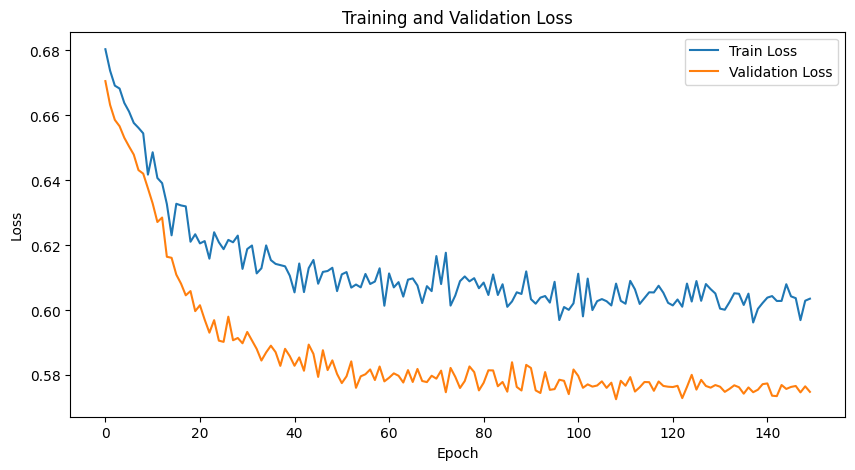

In [ ]:
max_nodes = 620


dataset = TUDataset(
    root='data/TUDataset',
    name='PROTEINS',
    #transform=T.ToDense(max_nodes),
    #pre_filter=lambda data: data.num_nodes <= max_nodes,
)

filtered_dataset = [data for data in dataset if data.num_nodes <= max_nodes]

dataset = dataset.shuffle()
n = (len(dataset) + 9) // 10
test_dataset = dataset[:n]
val_dataset = dataset[n:2 * n]
train_dataset = dataset[2 * n:]


node_counts = [data.num_nodes for data in filtered_dataset]
print(f"Maximum nodes in any graph: {max(node_counts)}")
print(f"Minimum nodes in any graph: {min(node_counts)}")




print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)
        x = self.dropout(x)
        x = self.lin(x)
        return x

model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def test(loader):
    model.eval()
    correct = 0
    total_loss = 0
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.batch)
            pred = out.argmax(dim=1)
            correct += int((pred == data.y).sum())
            loss = criterion(out, data.y)
            total_loss += loss.item()
    return correct / len(loader.dataset), total_loss / len(loader)

train_loss_history = []
val_loss_history = []

for epoch in range(1, 151):
    train_loss = train()
    train_acc, _ = test(train_loader)
    val_acc, val_loss = test(val_loader)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)  
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
    scheduler.step()

test_acc, test_loss = test(test_loader)
print(f'Final Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}')

plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


## 4. Challenges with flat GNNs <a id="challenges"></a>

Flat GNN architectures, such as GCN and GraphSage, encounter several significant challenges when dealing with complex graph data that have inherent hierarchical structures:

- **Over-smoothing**: When many layers are used in flat GNNs, node features across the graph can converge to similar values, making them indistinguishable from one another. This is particularly detrimental in tasks where node-specific features are crucial for performance.

- **Scalability**: The need to process entire adjacency matrices or compute features for all nodes simultaneously makes flat GNNs computationally expensive and memory-intensive, especially as graph sizes increase.

- **Lack of Hierarchical Representation**: Flat GNNs treat all connections equally and are typically not designed to recognize or exploit the hierarchical structure of graphs. Many real-world graphs (e.g., social networks, biological networks) exhibit hierarchical organization where nodes can be grouped at different levels of granularity. The inability to model these levels can limit the effectiveness of the learning process.

- **Inability to Capture Long-Range Dependencies**: These models generally focus on local neighborhood information, which restricts their capacity to learn long-range dependencies within the graph. In large graphs, important structural information might span large node distances, which flat architectures can fail to capture effectively.

- **Homophily Assumption Limitations**: Flat GNNs often operate under the assumption of homophily, where connected nodes are expected to be similar. However, many hierarchical graphs display heterophily at different scales, where nodes within the same community might not necessarily share close features, misleading the learning process in flat GNNs.


These challenges highlight the need for more sophisticated approaches like hierarchical GNNs, which can more effectively model the complexities of structured data at multiple scales and layers of abstraction.

Source - Hierarchical graph representation learning with differentiable pooling." (2019): [Ying, Zhitao, et al., Neurips(2019)]


## 5. Introduction to Hierarchical Graph Neural Networks <a id="hgnn"></a>

Hierarchical Graph Neural Networks (HGNNs) address some of the key limitations of traditional flat GNNs by organizing data into different levels of abstraction. This structure allows HGNNs to process large and complex graphs more efficiently by focusing on various graph features at different scales.

### 5.1 Efficient Computation through Coarsening <a id="coarsening"></a>

**Graph coarsening** is a technique used to reduce the size of the graph by combining nodes and edges into larger units. This simplifies the graph while trying to preserve its essential properties, such as connectivity and node relationships.

The coarsening operation can be expressed mathematically with a coarsening matrix \( C \). This matrix helps to map nodes from the original graph \( G \) to a new, smaller graph \( G' \). The transformation looks like this:

$$
H^{(l+1)} = C^{(l)} H^{(l)} W^{(l)}
$$

- $H^{(l)}$ is the matrix of node features at layer \( l \).
- $W^{(l)}$ is the weight matrix at layer \( l \), which transforms node features.
- $C^{(l)}$ is the coarsening matrix at layer \( l \), which reduces the number of nodes by merging them.

This process decreases the computational complexity and helps the model to focus on more global features as it goes deeper.

### 5.2 Capturing the Hierarchical Structure <a id="h_structure"></a>

Hierarchical GNNs are designed to capture the inherent multi-scale structure of graphs. By creating multiple abstraction levels, these networks can understand and utilize both local and global information effectively.

A common approach in HGNNs is to use a **pooling mechanism** that aggregates node features into a higher-level representation:

$$
H^{(l+1)} = \sigma \left( \text{AGGREGATE}\left( C^{(l)} H^{(l)} \right) W^{(l)} \right)
$$

- $\sigma$ is a nonlinear activation function that introduces nonlinearity into the model, helping it to learn more complex patterns.
- $\text{AGGREGATE}$ could be a function like sum, mean, or a more complex learned function, which combines the features of nodes that have been merged together.

This structure enables the model to efficiently process information from a broader context as it moves from one layer to the next.

Moreover, many hierarchical GNNs utilize mechanisms such as **DiffPool** to form a soft assignment matrix \( S^{(l)} \), which determines how nodes are grouped into clusters at each layer:

$$
S^{(l)} = \text{softmax}(\text{GNN}_{\text{pool}}(H^{(l)}, A))
$$

$$
H^{(l+1)} = S^{(l)T} H^{(l)} W^{(l)}
$$

- $S^{(l)}$ represents the probabilities of each node belonging to different clusters, learned adaptively by the network.
- This soft clustering allows the network to learn an optimal hierarchical representation by grouping together nodes that share similar features or roles within the graph.

These mechanisms help hierarchical GNNs to overcome the issues of over-smoothing, scalability, and capturing long-range dependencies that are prevalent in flat GNN architectures.

## 6. Diffpool Mechanism <a id="diffpool"></a>


DiffPool, short for Differentiable Pooling, is designed to enhance Graph Neural Networks (GNNs) by allowing for the hierarchical reduction of graph sizes through a learned pooling mechanism. This approach is especially beneficial for tasks such as graph classification where capturing different levels of abstraction in graph structure can be crucial.

### The DiffPool Layer

A DiffPool layer effectively performs two fundamental operations that transform the graph's node features and its structure:

1. **Node Embedding Update**: The first step in a DiffPool layer is updating the node features. This is typically achieved using a Graph Neural Network (GNN) model that processes the input features and the adjacency matrix:
   $$Z^{(l)} = \text{GNN}_{\text{embed}}^{(l)}(A^{(l-1)}, X^{(l-1)})$$
   Where $Z^{(l)}$ represents the node features updated by the GNN, $A^{(l-1)}$ is the adjacency matrix from the previous layer, and $X^{(l-1)}$ represents the node features from the previous layer. The choice of GNN can vary based on the specific requirements and may include architectures like GCNs, GATs, or more complex models.

2. **Cluster Assignment**: Simultaneously, another GNN predicts the assignment of nodes to various clusters. This assignment is soft, meaning each node can belong to multiple clusters to different extents:
   $$S^{(l)} = \text{softmax}(\text{GNN}_{\text{assign}}^{(l)}(A^{(l-1)}, X^{(l-1)}))$$
   The softmax function ensures that the assignment probabilities for each node across clusters sum to one, facilitating a probabilistic and differentiable clustering process.

### Graph Coarsening

The outputs from the node embedding update and the cluster assignment are then used to coarsen the graph:

- **Coarsened Node Features**:
  $$X^{(l)} = S^{(l)^T} Z^{(l)}$$
  This equation computes the new features for each cluster by aggregating the features of the nodes assigned to each cluster, weighted by their assignment probabilities.

- **Coarsened Adjacency Matrix**:
  $$A^{(l)} = S^{(l)^T} A^{(l-1)} S^{(l)}$$
  This updated adjacency matrix reflects the new graph structure, with nodes replaced by clusters. This matrix computation involves the multiplication of the transpose of the assignment matrix, the original adjacency matrix, and the assignment matrix, capturing how clusters are interconnected based on the node connections and their cluster memberships.

### Learning and Objective

The DiffPool layers are trained through backpropagation, minimizing a loss function that typically combines task-specific errors (like classification or regression errors) and regularization terms. Regularization might encourage the model to distribute nodes evenly across clusters or to use fewer clusters actively. This allows DiffPool not only to perform graph reduction efficiently but also to learn to capture and compress the most salient graph features relevant to the task.



## 7. Training a GNN using Diffpool Mechanism <a id="training_dp"></a>


### Model Definition

This section defines two neural network models: `GNN` and `Net`. `GNN` is a helper class designed for graph neural network layers with batch normalization. `Net` integrates these into a model capable of differentiating and pooling graph representations.


Epoch: 001, Train Loss: 0.6460, Train Acc: 0.5859, Val Loss: 0.6495, Val Acc: 0.5780
Epoch: 002, Train Loss: 0.6179, Train Acc: 0.5848, Val Loss: 0.6281, Val Acc: 0.7339
Epoch: 003, Train Loss: 0.6068, Train Acc: 0.6632, Val Loss: 0.5885, Val Acc: 0.7156
Epoch: 004, Train Loss: 0.5959, Train Acc: 0.6863, Val Loss: 0.5621, Val Acc: 0.7248
Epoch: 005, Train Loss: 0.5870, Train Acc: 0.7047, Val Loss: 0.5429, Val Acc: 0.7523
Epoch: 006, Train Loss: 0.5785, Train Acc: 0.7220, Val Loss: 0.5316, Val Acc: 0.7706
Epoch: 007, Train Loss: 0.5708, Train Acc: 0.7393, Val Loss: 0.5235, Val Acc: 0.7890
Epoch: 008, Train Loss: 0.5638, Train Acc: 0.7451, Val Loss: 0.5166, Val Acc: 0.7982
Epoch: 009, Train Loss: 0.5584, Train Acc: 0.7509, Val Loss: 0.5112, Val Acc: 0.7890
Epoch: 010, Train Loss: 0.5537, Train Acc: 0.7532, Val Loss: 0.5053, Val Acc: 0.7890
Epoch: 011, Train Loss: 0.5501, Train Acc: 0.7520, Val Loss: 0.5014, Val Acc: 0.8165
Epoch: 012, Train Loss: 0.5470, Train Acc: 0.7520, Val Loss: 0.49

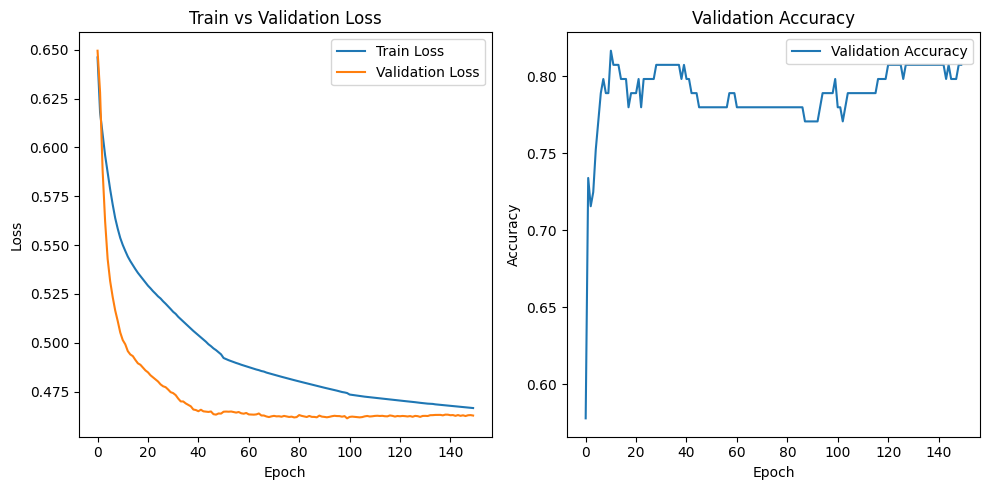

In [ ]:
max_nodes = 620

path = "./data"
dataset = TUDataset(
    path,
    name='PROTEINS',
    transform=T.ToDense(max_nodes),
    pre_filter=lambda data: data.num_nodes <= max_nodes,
)
dataset = dataset.shuffle()
n = (len(dataset) + 9) // 10
test_dataset = dataset[:n]
val_dataset = dataset[n:2 * n]
train_dataset = dataset[2 * n:]
test_loader = DenseDataLoader(test_dataset, batch_size=64)
val_loader = DenseDataLoader(val_dataset, batch_size=64)
train_loader = DenseDataLoader(train_dataset, batch_size=64)


class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, normalize=False, lin=True):
        super().__init__()
        self.conv1 = DenseSAGEConv(in_channels, out_channels, normalize)
        self.bn1 = torch.nn.BatchNorm1d(out_channels)
        self.lin = torch.nn.Linear(out_channels, out_channels) if lin else None

    def forward(self, x, adj, mask=None):
        x = self.conv1(x, adj, mask).relu()
        x = self.bn(1, x)
        if self.lin is not None:
            x = self.lin(x).relu()
        return x

    def bn(self, i, x):
        batch_size, num_nodes, num_channels = x.size()
        x = x.view(-1, num_channels)
        x = getattr(self, f'bn{i}')(x)
        x = x.view(batch_size, num_nodes, num_channels)
        return x


class Net(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.gnn1_pool = GNN(num_features, 64, ceil(0.25 * 640))  # Assuming max_nodes = 150
        self.gnn1_embed = GNN(num_features, 64, 64, lin=False)

        self.lin1 = torch.nn.Linear(64, 64)
        self.lin2 = torch.nn.Linear(64, num_classes)

    def forward(self, x, adj, mask=None):
        s = self.gnn1_pool(x, adj, mask)
        x = self.gnn1_embed(x, adj, mask)
        
        # Assuming dense_diff_pool is still used for demonstration purposes
        x, adj, _, _ = dense_diff_pool(x, adj, s, mask)  # Simplified handling of outputs

        x = x.mean(dim=1)
        x = self.lin1(x).relu()
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)


if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

model = Net(dataset.num_features, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=50 , gamma=0.5)
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_loss = float('inf')
patience = 80
trigger_times = 0



def train(epoch):
    model.train()
    loss_all = 0
    correct = 0
    total = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.adj, data.mask)  # Adjusted to expect only one output
        loss = F.nll_loss(output, data.y.view(-1))
        loss.backward()
        optimizer.step()
        loss_all += data.y.size(0) * float(loss)
        pred = output.max(dim=1)[1]
        correct += int(pred.eq(data.y.view(-1)).sum())
        total += data.y.size(0)
    train_loss = loss_all / len(train_dataset)
    train_accuracy = correct / total
    return train_loss, train_accuracy

@torch.no_grad()
def test(loader):
    model.eval()
    correct = 0
    loss_all = 0
    total = 0
    for data in loader:
        data = data.to(device)
        output = model(data.x, data.adj, data.mask)  # Adjusted here as well
        loss = F.nll_loss(output, data.y.view(-1))
        loss_all += data.y.size(0) * float(loss)
        pred = output.max(dim=1)[1]
        correct += int(pred.eq(data.y.view(-1)).sum())
        total += data.y.size(0)
    avg_loss = loss_all / len(loader.dataset)
    accuracy = correct / total
    return avg_loss, accuracy



best_val_acc = test_acc = 0
times = []
for epoch in range(1, 151):
    train_loss, train_accuracy = train(epoch)
    val_loss, val_accuracy = test(val_loader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    
    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
    
    scheduler.step()
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
    else:
        trigger_times += 1
    
    if trigger_times >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

# Test performance after training
test_loss, test_acc = test(test_loader)
train_loss, train_acc = test(train_loader)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Train vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Discussion <a id="discussion"></a>


**In the final iteration of the notebook**, code to visualise the the Proteins data of the TUDataset library was added. This iteration visualises the protein networks as undirected grapha as the first step. It then performs agglomerative clustering using Euclidean distance as the loss function to make 4 clusters(hard coded). It then also creates a dendogram to quantify the heirarchical structure in the molecules.

We also train a flat GCN based GNN classifer and get the Test Accuracy of 0.7232 on test set. Compared that to 0.7798 for the network trained by Diffpool mechanism. 

## Quiz <a id="quiz"></a>
1. What are the main advantages of using hierarchical graph neural networks (HGNNs) over flat graph neural network architectures, and how do these advantages impact computational efficiency and model performance?


2. Describe the DiffPool mechanism and explain how it contributes to the process of graph coarsening in the context of training graph neural networks.


3. Explain the role of the learnable embedding matrix in the DiffPool mechanism. How does it affect the hierarchical representation of graphs in training graph neural networks?